In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 张量操作

### 张量

使用`tf.constant`创建常数张量，该类型张量的元素无法更改  
通常数学操作，如使用`tf.add`与`tf.math.add`指向的是同一个函数，这是为了简化代码，但是也有不一样的。如对数只能写`tf.math.log`  
通常tf的张量运算函数名称与numpy的是一样的，但也有不一样的，比如`np.mean`对应的是`tf.reduce_mean`

In [2]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [3]:
t.shape

TensorShape([2, 3])

In [4]:
t.dtype

tf.float32

### 张量索引

tf中张量的索引方式与在numpy中是十分相似的

In [5]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [6]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [7]:
t[:, 1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

### 张量操作

In [8]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [10]:
# 矩阵乘法
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

### 使用`keras.backend`

keras.backend中也有像tf的诸如square()、exp()的函数，但是如果在tf.keras中使用这些keras的函数，那么其实还是会指向tf的函数

In [11]:
# 可见使用tf.keras.backend的运算函数其实还是tf的
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### 导入\导出为Numpy数组

<b><font color=red>注意:</font></b> numpy中的数组默认使用的64位精度，但是tf的张量默认使用32位精度。  
这是因为32位精度在神经网络训练中就已经绰绰有余了，而且还可以减少使用的内存，保障运行速度

In [12]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [13]:
# 张量转换成numpy数组
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [14]:
# tf函数可以处理numpy数组
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [15]:
# numpy函数可以处理tf张量
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### 类型转换

在tf中，不会自动转换张量类型，有点像静态语言  
比如不能把浮点张量与整数张量相加，甚至不能相加32位和64位浮点数  
所以如果张量要与numpy数组进行运算，记得确保位数一致

In [16]:
# 整数与浮点数张量无法运算
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [17]:
# 32位浮点数与64位浮点数无法运算
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [18]:
# 如果需要类型转换，可以使用tf.cast()
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### 字符串张量

表示字节字符串，而不是Python的Unicode字符串  
tf.strings是原子级的，所以不显示长度，但若将其用Unicode代码表示，就可以显示长度了

In [19]:
# 字节字符串
tf.constant("hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [20]:
# 基于UTF-8代码保存字符串
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [21]:
# 基于Ucicode代码保存字符串，可以在shape属性中显示字符串长度
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [22]:
# 使用tf.string对字符串进行编码，将Unicode字符串转换为UTF-8编码
b = tf.strings.unicode_encode(u, "UTF-8")
# 基于UTF8字符显示字符串长度
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [23]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

### 字符串数组

In [24]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [25]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [26]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

In [27]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>


### 不规则张量（Ragged tensors）

表示张量列表的静态列表，大小不可变，其中每个向量都有相同的形状和数据类型  
tf.ragged包含不规则张量的操作

In [28]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

In [29]:
# 以行的形式加入三行，长度不够的地方用0填充
r2 = tf.ragged.constant([[65, 66], [], [67]])
tf.concat([r, r2], axis=0).to_tensor()

<tf.Tensor: shape=(7, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0],
       [   65,    66,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0],
       [   67,     0,     0,     0,     0,     0]])>

In [30]:
# 以列的形式填充3列，优先填充目标行长度不够的位置（被0填充的位置），可以增加新的列
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
tf.concat([r, r3], axis=1).to_tensor()

<tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[   67,    97,   102,   233,    68,    69,    70],
       [   67,   111,   102,   102,   101,   101,    71],
       [   99,    97,   102,   102,   232,     0,     0],
       [21654, 21857,    72,    73,     0,     0,     0]])>

In [31]:
# 使用UTF-8编码
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

### 稀疏张量

In [32]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]], # 非零值的位置
                    values=[1., 2., 3.], # 菲零值
                    dense_shape=[3, 4]) # 形状

In [33]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [34]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [35]:
# 稀疏矩阵支持乘除法
s2 = s * 2.0

In [36]:
# 稀疏矩阵不支持加减操作
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [37]:
# 除非先将稀疏矩阵转换成dense矩阵
s4 = tf.sparse.to_dense(s) + 1.

In [38]:
# 矩阵乘法需调用sparse_dense_matmul方法
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [39]:
# 在构造稀疏矩阵的时候，最好是按照行和列的顺序定义各个位置的元素，不要像下面这样
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [40]:
# 否则就没办法转换成dense矩阵了
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] is out of order. Many sparse ops require sorted indices.
  Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [41]:
# 但是可以使用reorder方法来重新排序各元素的定义的顺序
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### 集合

就像Python中集合那样，可以合并重复值

In [42]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
# 得到最后
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

### 变量

前面的张量都是不能修改的，这就意味着其不能作为反向传播权重的载体  
变量类型的张量可以担负这个任务，但是一般不用使用者亲自修改

In [43]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [44]:
# 使用assign方法对张量进行修改
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [45]:
# 定点分配值
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [46]:
# 在切片中分配数值
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [47]:
# 不能直接指定
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [48]:
# 用scatter_nd_update方法也可以修改值
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [49]:
# 再或者向scatter_update方法中传入IndexedSlices实例来修改
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

### 张量数组

有点像动态数组，可以后续添加新的行

In [50]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [51]:
# 从数组中取出第二行
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [52]:
# 第二行元素被取走，用0填充原来的位置
# 以栈的形式展示数组
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [53]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [54]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

## 自定义模型和训练算法

### 自定义损失函数

以一个回归神经网络为例，数据的话还是拿加利福利亚房产数据  
首先要强调的是：如果想要自定义的损失函数可以从tensorflow的图形功能中受益，就要在函数中尽可能使用向量化实现

In [55]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [63]:
# 自定义一个损失函数：huber损失函数，虽然keras.loss中有它的实现。但是这里非要自己做
# 注意这里的向量要尽可能用tf的张量函数来表示
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

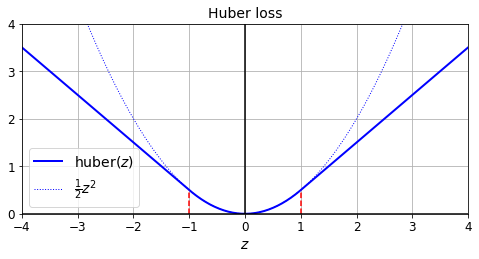

In [57]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [60]:
input_shape = X_train.shape[1:]

# 来建立一个非常简单的网络
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

# 这里输入自定义的huber损失函数
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.5672 - mae: 0.9244 - val_loss: 0.2994 - val_mae: 0.5979
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2133 - mae: 0.5100 - val_loss: 0.2551 - val_mae: 0.5446


### 保存\加载使用了自定义对象的模型

在脚本中使用自定义的损失函数很方便，但是要是加载一个使用了自定义函数的模型就麻烦了，因为在保存模型的时候是不会把自定义的对象也给保存了的

In [61]:
model.save("my_model_with_a_custom_loss.h5")

In [62]:
# 模型在保存的时候会将自定义的对象名称当做一个字典的键保存起来
# 在加载的时候只需要向字典中对应的键传递相应的对象就行了
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [64]:
# 可见此时网络是可以正常训练的
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2023 - mae: 0.4935 - val_loss: 0.2163 - val_mae: 0.4991
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1963 - mae: 0.4854 - val_loss: 0.1831 - val_mae: 0.4667


In [65]:
# 如果想要改变huber函数中的误差的阈值，可以这么写
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [66]:
# 然后被这样调用
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2171 - mae: 0.4844 - val_loss: 0.2128 - val_mae: 0.4676
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2132 - mae: 0.4804 - val_loss: 0.2193 - val_mae: 0.4759


In [67]:
# 但是有一个问题，那就是在保存模型的时候不会保存自定义的阈值
model.save("my_model_with_a_custom_loss_threshold_2.h5")

# 并且在加载的时候键仍是huber_fn，需要手动指定阈值
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [68]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2113 - mae: 0.4776 - val_loss: 0.2067 - val_mae: 0.4616
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2083 - mae: 0.4740 - val_loss: 0.2160 - val_mae: 0.4712


In [74]:
# 当然对于这种情况也不是没有办法解决
# 那就是自定义一个Huber损失的类，继承自keras.losses.Loss类
# 记得要实现get_config方法，这样就可以把想要的超参数保存自动保存下来了
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        # 注意这里调用了父类的get_config方法
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [70]:
# 新建一个模型来举例
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.7858 - mae: 0.9519 - val_loss: 0.2471 - val_mae: 0.5119
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2372 - mae: 0.5116 - val_loss: 0.2498 - val_mae: 0.5049


In [72]:
model.save("my_model_with_a_custom_loss_class.h5")

# 可见此时再加载，键就是HuberLoss了，并且也不用再重新输入HuberLoss的超参数阈值了，只需要输入类名就行了
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2277 - mae: 0.5005 - val_loss: 0.2174 - val_mae: 0.4772
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2215 - mae: 0.4930 - val_loss: 0.2023 - val_mae: 0.4711


In [73]:
# 检查一遍看看阈值是不是后来定义的2，而不是默认的1
model.loss.threshold

2.0

### 自定义激活函数、初始化、正则化和约束

只需要特定的输入输出，自定义的函数就能作为keras大多数的功能如：损失、正则化、约束、初始化、指标、激活函数、层甚至完整的模型  
参数的类型取决于自定义函数的类型

In [75]:
# 激活函数自定义
# 等同于tf.nn.softplus(z)和keras.activations.softplus(z)
def my_softplus(z): 
    return tf.math.log(tf.exp(z) + 1.0)

# 自定义初始化
# 等同于keras.initializers.glorot_normal()
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

# 自定义l1正则项
# 等同于keras.regularizers.l1(0.01)
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

# 确保权重全为正的自定义约束
# 等同于keras.contraints.nonneg()或tf.nn.relu()
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [76]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [78]:
# 可以用自定义的函数组成一个模型
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.5620 - mae: 0.8542 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6940 - mae: 0.5377 - val_loss: inf - val_mae: inf


In [79]:
# 在加载带有自定义函数的模型时，同样需要在对应字典的键映射对应的函数
model.save("my_model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

但是如果像上面那样定义函数，函数的超参数是不能与模型一起保存的  
如果想自定义函数的超参数与模型一起保存，就需要继承对应的基类，如：  
  
正则化：`keras.regularizers.Regularizer`  
约束：`keras.constraints.Constraint`  
初始化：`keras.initializers.Initializer`  
层或激活函数：`keras.layers.Layer`  
  
当然还有需要自定义一些方法：  
如果自定义的是损失、层或激活函数或模型，需要自定义call()方法；  
如果自定义的是正则化、初始化或约束，需要自定义__call__()方法。
指标的情况就比较特殊了，暂时不提

In [80]:
# 自定义正则化类
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    # 可以看到这里没有用父类的get_config()方法，这是因为父类就没有这个方法
    def get_config(self):
        return {"factor": self.factor}

In [81]:
# 设置factor为0.01
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.6236 - mae: 0.9449 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 1.1209 - mae: 0.5592 - val_loss: inf - val_mae: inf


In [83]:
# 再保存后导入，此时的factor肯定是0.01
model.save("my_model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })